In [81]:
import pickle
import datetime

import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader

import numpy as np
import seaborn
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tensorboard import SummaryWriter

# Data loading
- Load csv into three separate pytorch "DataLoader"s, train, validation, and test.

In [7]:
dataset_ = pd.read_csv('./oracle_data.csv')

# Pick out data only where object pose changed
changed_inds = (dataset_['y_0'] != dataset_['y\'_0']) | (dataset_['y_1'] != dataset_['y\'_1']) | (dataset_['y_2'] != dataset_['y\'_2'])
dataset_ = dataset_[changed_inds]
dataset = dataset_.copy()

# Ignore robot successor state
dataset = dataset[[c for c in dataset.columns if 'x\'' not in c]]

# robot relative position
object_pos = dataset[[c for c in dataset.columns if 'y_' in c]]
for i in range(2):
    dataset.loc[:, 'x_{}'.format(i)] -= dataset['y_{}'.format(i)].values
# relative object change
for i in range(3):
    dataset.loc[:, 'y\'_{}'.format(i)] -= dataset['y_{}'.format(i)].values
# drop initial object x, y
dataset = dataset[[c for c in dataset.columns if c not in ['y_0', 'y_1']]]

# Remake angles θ to cos(θ), sin(θ). Redo as more automatically?
angles = dataset['x_2'].copy()
dataset['x_2'] = angles.apply('cos')
dataset['x_3'] = angles.apply('sin')
angles = dataset['y_2'].copy()
dataset['y_2'] = angles.apply('cos')
dataset['y_3'] = angles.apply('sin')
angles = dataset['y\'_2'].copy()
dataset['y\'_2'] = angles.apply('cos')
dataset['y\'_3'] = angles.apply('sin')

dataset = dataset[['x_0', 'x_1', 'x_2', 'x_3', 'y_2', 'y_3', 'y\'_0', 'y\'_1', 'y\'_2', 'y\'_3',
                   'u_0', 'u_1', 'u_2', 'u_3', 'u_4']]

# Decide where to split in training/validation/test
train_cut = int(len(dataset) * 0.9)
valid_cut = train_cut + int(len(dataset) * 0.05)
dataset_train_ = dataset[:train_cut]
dataset_val_ = dataset[train_cut:valid_cut]
dataset_test_ = dataset[valid_cut:]

# Normalize by training set statistics
training_µ = dataset_train_.mean()
training_σ = dataset_train_.std()
dataset_train = (dataset_train_ - training_µ) / training_σ
dataset_val = (dataset_train_ - training_µ) / training_σ
dataset_test = (dataset_train_ - training_µ) / training_σ

def get_dataloader(dataset, batch_size=32):
    X = dataset[[name for name in dataset.columns if not name.startswith('u')]]
    Y = dataset[[name for name in dataset.columns if name.startswith('u')]]
    return DataLoader(
        list(zip(X.as_matrix().astype(np.float32), Y.as_matrix().astype(np.float32))),
        batch_size=batch_size,
        shuffle=True
    )

dataloader_train = get_dataloader(dataset_train)
dataloader_val = get_dataloader(dataset_val, batch_size=128)
dataloader_test = get_dataloader(dataset_test, batch_size=128)

In [8]:
# redo same step to get input/output dimensions
X = dataset[[name for name in dataset.columns if not name.startswith('u')]]
Y = dataset[[name for name in dataset.columns if name.startswith('u')]]
x_size = len(X.columns)
y_size = len(Y.columns)
x_size, y_size

(10, 5)

# Define models
- Separate mean and variance models, for stability
- MSE loss for the mean, gaussian log likelihood for the variance

In [13]:
def n_fn(k):
    return int(k * (1 + k) / 2)


def k_fn(n):
    return int(-0.5 + (0.25 + 2 * n) ** 0.5)


hidden_size = 256
n_residual_units = 3
n_cholesky_entries = n_fn(y_size)


class CovarianceCholesky(torch.nn.Module):

    def __init__(self, n_features):
        super(CovarianceCholesky, self).__init__()
        self.k = n_features
        self.n = int(self.k * (1 + self.k) / 2)
        self.row_inds = []
        self.col_inds = []
        self.diagonal_inds = list(range(self.k))
        for i in range(1, self.k):
            for j in range(i):
                self.row_inds.append(i)
                self.col_inds.append(j)

    def forward(self, x):
        n = x.size(1)
        k = int(-0.5 + (0.25 + 2 * n) ** 0.5)
        y = Variable(torch.zeros(x.size(0), k, k))
        if x.data.is_cuda:
            y = y.cuda()
        y[:, self.row_inds, self.col_inds] = x[:, :n - k]
        y[:, self.diagonal_inds, self.diagonal_inds] = F.softplus(x[:, n - k:])
        return y

class Residual(torch.nn.Module):
    
    def __init__(self, num_features):
        super(Residual, self).__init__()
        self.bn1 = torch.nn.BatchNorm1d(num_features)
        self.fc1 = torch.nn.Linear(num_features, num_features)
        self.bn2 = torch.nn.BatchNorm1d(num_features)
        self.fc2 = torch.nn.Linear(num_features, num_features)
        
    def forward(self, x):
        a = self.fc1(F.relu(self.bn1(x)))
        b = self.fc2(F.relu(self.bn2(a)))
        return b + x
    

mean_model = torch.nn.Sequential(
    torch.nn.Linear(x_size, hidden_size),
    *[Residual(hidden_size) for _ in range(n_residual_units)],
    torch.nn.Linear(hidden_size, y_size)
).cuda()

var_model = torch.nn.Sequential(
    torch.nn.Linear(x_size, hidden_size),
    *[Residual(hidden_size) for _ in range(n_residual_units)],
    torch.nn.Linear(hidden_size, y_size),
    torch.nn.Softplus()
).cuda()

## Loss and optimizers

In [16]:
def gaussian_likelihood():
    def f(µ, σ, y):
        return (torch.log(σ) + 0.5 * (µ - y) * (µ - y) / (σ ** 2)).sum()
    return f

def multivariate_gaussian_likelihood(µ, L, y):
    """(Average) Negative log-likelihood of a multivariate gaussian.
    
    Notation below:
    n = Number of samples
    k = Dimensionality of gaussian variables

    µ : Variable, dimensions: (n, k)
    L : Lower triangular cholesky decomposition of the covariance matrices, that is LL' = Σ
        dimensions: (n, k, k)
    y : Variable, dimensions: (n, k)
    """
    n, k = µ.size()
    nll = Variable(torch.zeros(1))
    if µ.data.is_cuda:
        nll = nll.cuda()
    for i in range(n):
        l = L[i, :, :]
        L_inv = torch.inverse(l)
        Σ_inv = L_inv.transpose(0, 1) @ L_inv
        d = y[i:i + 1, :] - µ[i:i + 1, :]
        logdet = 2 * torch.log(l.diag()).sum()
        nll += 0.5 * (
            logdet +
            (d @ Σ_inv @ d.transpose(0, 1)).sum() +
            k * np.log(2 * np.pi)
        )
    return nll / n

mean_loss_fn = torch.nn.MSELoss()
mean_optim = torch.optim.Adam(mean_model.parameters(), weight_decay=1e-4)
var_loss_fn = gaussian_likelihood()
var_optim = torch.optim.Adam(var_model.parameters(), weight_decay=1e-4)

time_str = datetime.datetime.now().strftime('%H:%M')
logger_train = SummaryWriter('runs/resid-6-hidden-256-wd-1e-4-time-{}-relative-train'.format(time_str))
logger_valid = SummaryWriter('runs/resid-6-hidden-256-wd-1e-4-time-{}-relative-valid'.format(time_str))

In [66]:
#best_val = np.inf
#best_mean_model = None
#best_var_model = None
#step = 0
for _ in range(1024):
    for batch in dataloader_train:
        mean_model.train()
        var_model.train()
        X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), batch)
        Y_mean_pred = mean_model(X)
        Y_var_pred = var_model(X)

        mean_model.zero_grad()
        var_model.zero_grad()

        mse = mean_loss_fn(Y_mean_pred, Y)
        mse.backward(retain_graph=True)
        mean_optim.step()

        nll = var_loss_fn(Y_mean_pred, Y_var_pred, Y)
        nll.backward()
        var_optim.step()

        if step % 500 == 0:
            logger_train.add_scalar('mse', mse.cpu().data.numpy()[0], step)
            logger_train.add_scalar('nll', nll.cpu().data.numpy()[0], step)
            
            mean_model.eval()
            var_model.eval()
            val_batch = next(iter(dataloader_val))
            X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), val_batch)
            Y_mean_pred = mean_model(X)
            Y_var_pred = var_model(X)

            mse_val = mean_loss_fn(Y_mean_pred, Y)
            nll_val = var_loss_fn(Y_mean_pred, Y_var_pred, Y).cpu().data.numpy()[0]
            
            logger_valid.add_scalar('mse', mse_val.cpu().data.numpy()[0], step)
            logger_valid.add_scalar('nll', nll_val, step)
            
            if nll_val < best_val:
                best_val = nll_val
                best_mean_model = mean_model.state_dict()
                best_var_model = var_model.state_dict()

        step += 1

KeyboardInterrupt: 

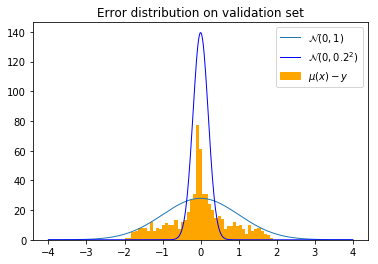

In [67]:
mean_model.load_state_dict(best_mean_model)
var_model.load_state_dict(best_var_model)
mean_model.eval()
var_model.eval()
val_batch = next(iter(dataloader_val))
X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), val_batch)
Y_mean_pred = mean_model(X)
Y_var_pred = var_model(X)
e = (Y_mean_pred - Y).cpu().data.numpy().flatten()
ts = np.linspace(-4, 4, 400)
handle_normal, = plt.plot(ts, 70 * norm.pdf(ts), alpha=1.0, label='$\mathcal{N}(0, 1)$', linewidth=1.0)
handle_normal2, = plt.plot(ts, 70 * norm.pdf(ts, loc=0, scale=1 / 5.0), alpha=1.0, color='blue', label='$\mathcal{N}(0, 0.2^2)$', linewidth=1.0)
error_handle = mpatches.Patch(color='orange', label='$µ(x) - y$')
out = plt.hist(e, bins=np.linspace(-4, 4, 100), color='orange')
plt.title('Error distribution on validation set')
plt.legend(handles=[handle_normal, handle_normal2, error_handle])
#plt.savefig('error_distribution.pdf')
plt.show()

In [22]:
float_formatter = lambda x: "%.4f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

In [80]:
val_batch = next(iter(dataloader_val))
X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), val_batch)
Y_mean_pred = mean_model(X).cpu().data.numpy()
Y_var_pred = var_model(X).cpu().data.numpy()
mean_pred = Y_mean_pred * training_σ.values[-5:] + training_μ.values[-5:]
std_pred = Y_var_pred * training_σ.values[-5:]
y_true = Y.cpu().data.numpy() * training_σ.values[-5:] + training_µ.values[-5:]
X[0, 6:8], mean_pred[0], y_true[0], std_pred[0]

(Variable containing:
 1.00000e-03 *
   1.4194
  -8.6644
 [torch.cuda.FloatTensor of size 2 (GPU 0)],
 array([-0.1361, 0.1044, 0.0300, 0.5658, 0.3770]),
 array([-0.6648, 1.6073, -1.4567, 0.9170, 0.0200]),
 array([1.1253, 1.1295, 0.8637, 0.2488, 0.4508]))

In [82]:
#with open('oracle-3-units-256-hidden-mean.pkl', 'wb') as f:
#    pickle.dump(mean_model.state_dict(), f)